In [13]:
from rasterio import features
from shapely.geometry import shape
import rasterio
import pickle
import numpy as np
from rasterio import mask
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from shapely import MultiPolygon, Polygon
from shapely.geometry import box

In [14]:
dir_list = os.listdir("./hour_graphs/") 
isoc = {}
max_box = [0,0]
centers = {}
bigs = {}
for i in tqdm(range(len(dir_list))):
    with open(f"../data/hour_graphs/{dir_list[i]}", "rb") as file:
        hr_graph = pickle.load(file)
        with rasterio.open('./landscape/Input_Geotiff.tif') as f:
            image = f.read(1)
            transform = f.transform
            crs = f.crs
            # use f.nodata if possible; it's not defined on this particular image
            nodata = -9999.0
            dims = f.read(1).shape
            mask = np.zeros(dims, dtype=np.bool_).astype(np.uint8)
            for t in hr_graph:
                for k,j in hr_graph[t][0]:
                    idx = np.unravel_index(k - 1, (1173, 1406))
                    if image[idx[0], idx[0]] != nodata:
                        if idx[0] < 0 or idx[1] < 0:
                            print(i)
                        mask[(idx[0]),(idx[1])] = True
                    idx2 = np.unravel_index(j - 1, (1173, 1406))
                    if image[idx2[0], idx2[0]] != nodata:
                        if idx2[0] < 0 or idx2[1] < 0:
                            print(i)
                        mask[(idx2[0]),(idx2[1])] = True
            polygons = []
            for coords, value in features.shapes(mask, transform = transform):
                # ignore polygons corresponding to nodata
                if value != 0:
                    # convert geojson to shapely geometry
                    geom = shape(coords)
                    polygons.append(geom)
            # use the feature loop in case you polygon is a multipolygon
            if mask.sum():
                features_ = [0]
                multi_p = MultiPolygon(polygons) # add crs using wkt or EPSG to have a .prj file
                min_x, min_y, max_x, max_y = multi_p.bounds
                bounding_box = ((max_x - min_x), (max_y - min_y))
                if bounding_box[0] > max_box[0]:
                    max_box[0] = bounding_box[0]
                    if max_box[0]//80 > 500:
                        print("Found a big one (x)!")
                        bigs[i] = max_box
                if bounding_box[1] > max_box[1]:
                    max_box[1] = bounding_box[1]
                    if max_box[1]//80 > 500:
                        print("Found a big one (y)!")
                        bigs[i] = max_box
                centers[i] = multi_p.centroid

100%|███████████████████████████████████████| 9730/9730 [08:51<00:00, 18.32it/s]


  8%|██▉                                   | 641/8326 [41:37<8:19:03,  3.90s/it]


KeyboardInterrupt: 

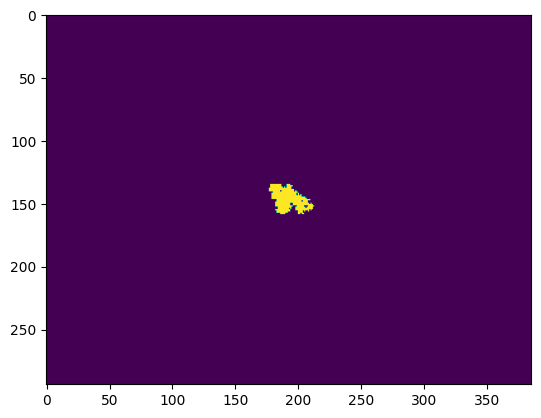

In [15]:
bbox = max_box
pad = 80
with rasterio.open('./landscape/Input_Geotiff.tif') as f:
    limits = f.bounds
    limits_x = (limits[0], limits[2])
    limits_y = (limits[1], limits[3])
    dims = f.read(1).shape
    image = f.read(1)
    transform = f.transform
dir_list = os.listdir("./hour_graphs/") 
for i in tqdm(centers):
    x, y = centers[i].x, centers[i].y
    max_x = x + (bbox[0]/2)
    min_x = x - (bbox[0]/2)
    max_y = y + (bbox[1]/2)
    min_y = y - (bbox[1]/2)
    if max_x > limits[2]:
        delta = limits[2] - max_x
        max_x += delta
        min_x += delta
    if max_y > limits[3]:
        delta = limits[3] - max_y
        max_y += delta
        min_y += delta
    if min_x < limits[0]:
        delta = limits[0] - min_x
        max_x += delta
        min_x += delta
    if min_y < limits[1]:
        delta = limits[1] - min_y
        max_y += delta
        min_y += delta
    indices = ((bbox[1]))
    ## CHECK:
    if max_x > limits_x[1] or max_y > limits_y[1] or min_x < limits_x[0] or min_y < limits_y[0]:
        print(max_x, min_x, max_y, min_y)
        raise Exception("Out of bounds!")  
    # box(minx, miny, maxx, maxy, ccw=True)
    geom = box(min_x, min_y, max_x, max_y)
    gdr = gpd.GeoDataFrame({'feature': features_, 'geometry': geom}, crs=crs)
    gdr.to_file(f"./shapes/box_{i}.shp")
    with open(f"../data/hour_graphs/{dir_list[i]}", "rb") as file:
        hr_graph = pickle.load(file)
    nodata = -9999.0
    mask = np.zeros(dims, dtype=np.bool_).astype(np.uint8)
    shape = (int(max_box[1])//80, int(max_box[0]//80))
    mask_ = np.zeros(shape, dtype=np.bool_).astype(np.uint8)
    for t in hr_graph:
        iso = np.zeros(dims, dtype=np.bool_).astype(np.uint8)
        iso_ = np.zeros(shape)
        for k,j in hr_graph[t][0]:
            idx = np.unravel_index(k - 1, (1173, 1406))
            if image[idx[0], idx[0]] != nodata:
                mask[(idx[0]),(idx[1])] = True
                iso[(idx[0]),(idx[1])] = True
                coords = rasterio.transform.xy(transform, idx[0], idx[1])
                x = int(coords[0] - min_x) // 80
                y = int(max_y - coords[1]) // 80 
                mask_[y,x] = True
                iso_[y,x] = True
            idx2 = np.unravel_index(j - 1, (1173, 1406))
            if image[idx2[0], idx2[0]] != nodata:
                mask[(idx2[0]),(idx2[1])] = True
                iso[(idx2[0]),(idx2[1])] = True
                coords = rasterio.transform.xy(transform, idx2[0], idx2[1])
                x = int(coords[0] - min_x) // 80 
                y = bottom=int(max_y - coords[1]) // 80
                mask_[y,x] = True
                iso_[y,x] = True
        np.savez_compressed(f'spreads/fire_{i}-{t}', mask_)
        np.savez_compressed(f'spreads/iso_{i}-{t}', iso_)
    plt.imshow(mask_)
    plt.savefig(f"fires/fires-{i}.png")
    